In [41]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)



In [36]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])




In [37]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

import seaborn as sns
from causalgraphicalmodels import CausalGraphicalModel
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [43]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    conf_mult = 1
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## 1. Experiments with covariates in the DGP

$y_i = \tau*T_i+\beta'*x_i+e_i$

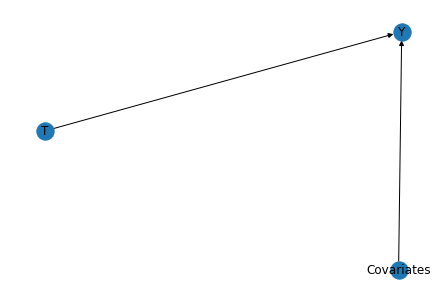

In [44]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='Covariates')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()


In [74]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 5 # number of covariates used in the DGP
flagX = 1
N = 1000
data1 = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
a = pd.DataFrame(data1[0])
b = pd.DataFrame(data1[1])
c = pd.DataFrame(data1[2])
data1=pd.concat([a,b,c],axis=1)
data1.to_csv('data1.csv')

### DGP with covariates not controlled

In [48]:
estDict = {}
R = 1500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1500/1500 [00:08<00:00, 174.41it/s]


In [49]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.02762390213124212, RMSE=4.418838926393954, size=0.048
N=1000: bias=-0.014274505749219435, RMSE=1.4435485099634011, size=0.04933333333333333


### DGP with covariates controlled

In [50]:
estDict = {}
R = 1500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1500/1500 [00:09<00:00, 154.06it/s]


In [51]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0013485048863627423, RMSE=0.14464166265378922, size=0.05333333333333334
N=1000: bias=-0.00017718718445405808, RMSE=0.04565906868838829, size=0.052


Example:  
T: Sunny weather or not  
Y: Mood  
Covariates: Grade, Relationship, Bank balance

## 2. Experiments with a confounder in the DGP

$y_i = \tau*T_i+0.6*Confounder+e_i$   

$T_i = 0.2*Confounder+u_i$

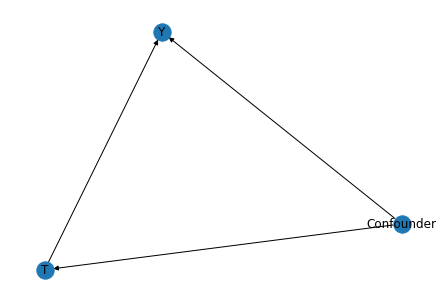

In [31]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='Confounder')
G.add_edge('s2','s1')
G.add_edge('s3','s2')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()


In [53]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1]) # confounder
     
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.6*C+err
    Tab = T+0.2*C

    return (Yab,Tab,C)

In [73]:
tau = 2
corr = .5
p = 10
data2 = fn_generate_data_conf(tau,N,p,corr)
a = pd.DataFrame(data2[0])
b = pd.DataFrame(data2[1])
c = pd.DataFrame(data2[2])
data2=pd.concat([a,b,c],axis=1)
data2.to_csv('data2.csv')

### DGP with a confounder not controlled

In [55]:
estDict = {}
R = 1500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,Texp,C = fn_generate_data_conf(tau,N,p,corr)
        const = np.ones([N,1])
        covars = np.concatenate([Texp,const],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]

        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1500/1500 [00:08<00:00, 169.12it/s]


In [59]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.00023322243022087157, RMSE=0.14340148703450442, size=0.054
N=1000: bias=-0.0006868476998701479, RMSE=0.044470315272995914, size=0.048666666666666664


### DGP with covariates controlled

In [60]:
estDict = {}
R = 1500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,Texp,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([Texp,C],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1500/1500 [00:09<00:00, 163.56it/s]


In [61]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.001119774350249634, RMSE=0.14215663161733919, size=0.06
N=1000: bias=-0.0029724492450512075, RMSE=0.04584245056330179, size=0.056666666666666664


Example:  
T: Education  
Y: Salary  
C: IQ

## 3. Experiments with selection bias in the DGP

$y_i = \tau*T_i+e_i$   

$z_i = 0.2*y_i+0.2*T_i+u_i$

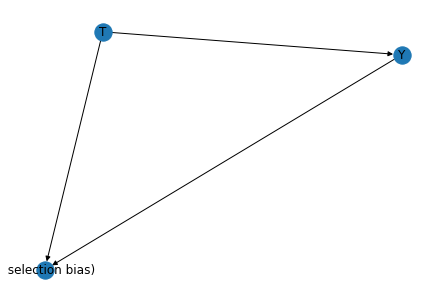

In [34]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='Z(selection bias)')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()


In [63]:
def fn_generate_data_sele(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
     
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Yab = tau*T+err
    Zab = 0.25*T+0.71*Yab+U

    return (Yab,T,Zab)

In [72]:
tau = 2
corr = .5
p = 10
N = 1000
data3 = fn_generate_data_sele(tau,N,p,corr)
a = pd.DataFrame(data3[0])
b = pd.DataFrame(data3[1])
c = pd.DataFrame(data3[2])
data3=pd.concat([a,b,c],axis=1)
data3.to_csv('data3.csv')

### DGP with selection bias not controlled

In [65]:
estDict = {}
R = 1500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Zab = fn_generate_data_sele(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1500/1500 [00:08<00:00, 175.52it/s]


In [66]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0022246367030687394, RMSE=0.1977338634215218, size=0.05733333333333333
N=1000: bias=-0.001133622351034174, RMSE=0.05990854707611724, size=0.03666666666666667


### DGP with selection bias controlled

In [67]:
estDict = {}
R = 1500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Zexp = fn_generate_data_sele(tau,N,p,corr)
        covars = np.concatenate([T,Zexp],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1500/1500 [00:09<00:00, 162.07it/s]


In [68]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.7884517942533185, RMSE=0.8047473081940858, size=0.9953333333333333
N=1000: bias=-0.7894583416024924, RMSE=0.7911617319370973, size=1.0


Examples:  
T: Medicine for heart disease  
Y: Regular heart or not  
Z: Death